# Continual Unlearning Results Visualization for CIFAR-100

This notebook analyzes and visualizes the performance of different continual unlearning methods on the CIFAR-100 dataset. We'll load results from CSV files and compare various methods against the ground truth (retrain_continual_unlearn).

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
df = pd.read_csv('eval_results_for_cifar10.csv')

In [3]:
# First, identify all the relevant columns we want to calculate gaps for
LP_columns = [col for col in df.columns if "test_LP_accuracy_class" in col]
class_indices = sorted(list(set([col.split("_")[-1] for col in LP_columns]))) # Ensure unique and sorted

retrain_df_base = df[df['method'] == 'retrain']
all_gap_data_frames = []

for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name].copy() # Work on a copy for this model
    retrain_df_model = retrain_df_base[retrain_df_base['model'] == model_name]
    gap_data_model = {}

    if retrain_df_model.empty:
        print(f"No 'retrain' data found for model {model_name}. Skipping gap calculation for this model.")
        continue

    for end_idx in sorted(retrain_df_model.forget_class_end.unique()):
        tmp_retrain_end_idx_df = retrain_df_model[retrain_df_model.forget_class_end == end_idx]
        
        if tmp_retrain_end_idx_df.empty:
            continue
            
        # Baseline values for this model and end_idx
        baseline_values_for_model_end_idx = {}
        for class_idx_str in class_indices:
            col_name = f'test_LP_accuracy_class_{class_idx_str}'
            if col_name in tmp_retrain_end_idx_df.columns:
                baseline_values_for_model_end_idx[class_idx_str] = tmp_retrain_end_idx_df[col_name].values[0]

        # Apply to all methods for the current model and matching classes_forgotten
        mask = (model_df.forget_class_end == end_idx)

        for class_idx_str in class_indices:
            if class_idx_str in baseline_values_for_model_end_idx:
                baseline_value = baseline_values_for_model_end_idx[class_idx_str]
                current_col_name = f'test_LP_accuracy_class_{class_idx_str}'
                gap_column_name = f'LP_gap_{class_idx_str}'
                
                if gap_column_name not in gap_data_model:
                    gap_data_model[gap_column_name] = pd.Series(index=model_df.index, dtype=float)
                
                if current_col_name in model_df.columns:
                    gap_data_model[gap_column_name].loc[mask] = model_df.loc[mask, current_col_name] - baseline_value
    
    # Add all gap columns for the current model
    if gap_data_model:
        gap_df_model = pd.DataFrame(gap_data_model, index=model_df.index)
        model_df_with_gaps = pd.concat([model_df.reset_index(), gap_df_model.reset_index(drop=True)], axis=1).set_index('index')
        all_gap_data_frames.append(model_df_with_gaps)

# Concatenate all model dataframes with their calculated gaps
if all_gap_data_frames:
    df = pd.concat(all_gap_data_frames)
    gap_cols_overall = [col for col in df.columns if col.startswith('LP_gap_')]
    df[gap_cols_overall] = df[gap_cols_overall].fillna(np.nan)
else:
    print("No gap data was generated.")

df.head()

,method,model,dataset,forget_class_begin,forget_class_end,classes_forgotten,unlearning_time,accuracy_retain,accuracy_forget,accuracy_val,...,LP_gap_0,LP_gap_1,LP_gap_2,LP_gap_3,LP_gap_4,LP_gap_5,LP_gap_6,LP_gap_7,LP_gap_8,LP_gap_9
index,,,,,,,,,,,,,,,,,,,,,
0,FT,resnet18,cifar10,0,0,0,140.652017,93.259259,0.0,83.18,...,-1.599998,-1.600006,-3.900002,-6.900002,-4.400002,-7.199997,-1.899994,-2.900002,-0.299995,-2.800003
1,FT,resnet18,cifar10,0,1,1,126.142376,93.652778,0.0,74.22,...,0.300003,26.799999,-6.300003,-5.900002,-5.000000,-5.300003,-4.299995,-3.300003,-0.799995,9.800003
2,FT,resnet18,cifar10,0,2,2,113.525857,94.006349,0.0,65.86,...,12.599998,19.500000,5.100002,0.000000,1.099998,-1.900002,0.199997,-0.800003,-1.700005,-2.000000
3,FT,resnet18,cifar10,0,3,3,97.489237,97.833333,0.0,58.46,...,13.699997,18.200001,24.400002,22.500000,2.900002,1.699997,0.400002,-0.900002,-0.400002,7.800003
4,FT,resnet18,cifar10,0,4,4,84.594697,98.475556,0.0,49.24,...,10.600002,19.200005,26.000000,23.899998,29.799999,3.299995,-0.700005,1.899994,-0.500000,3.500000


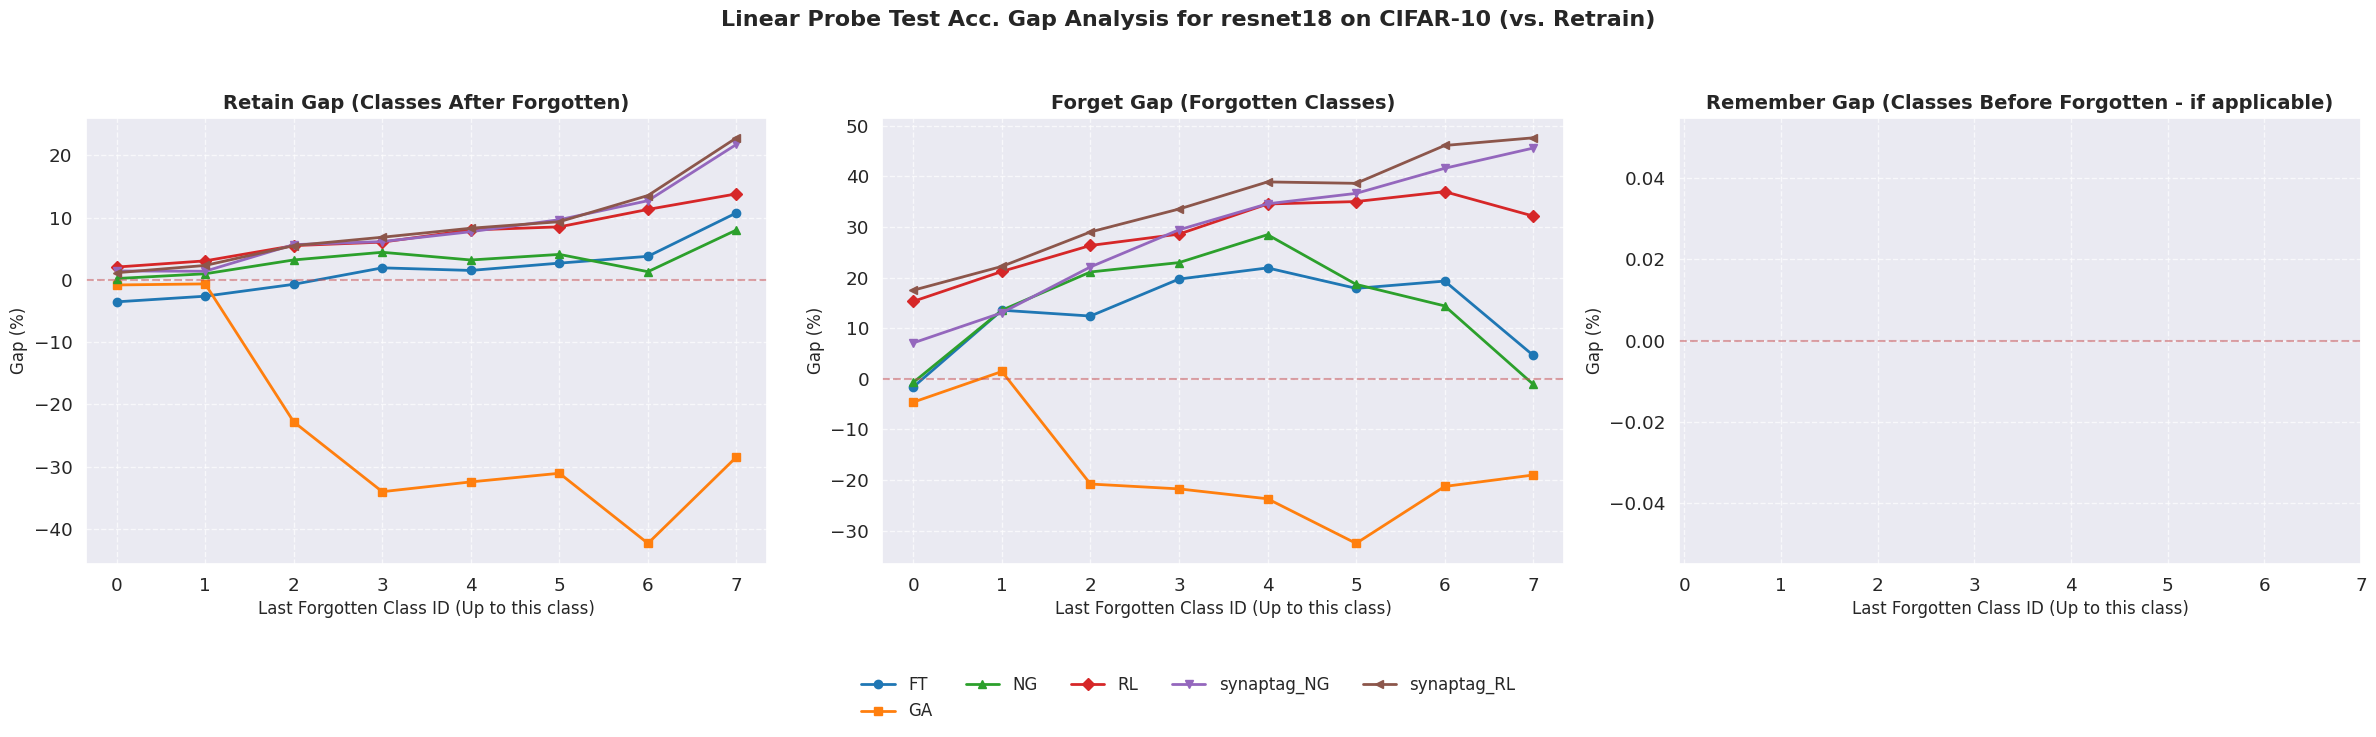

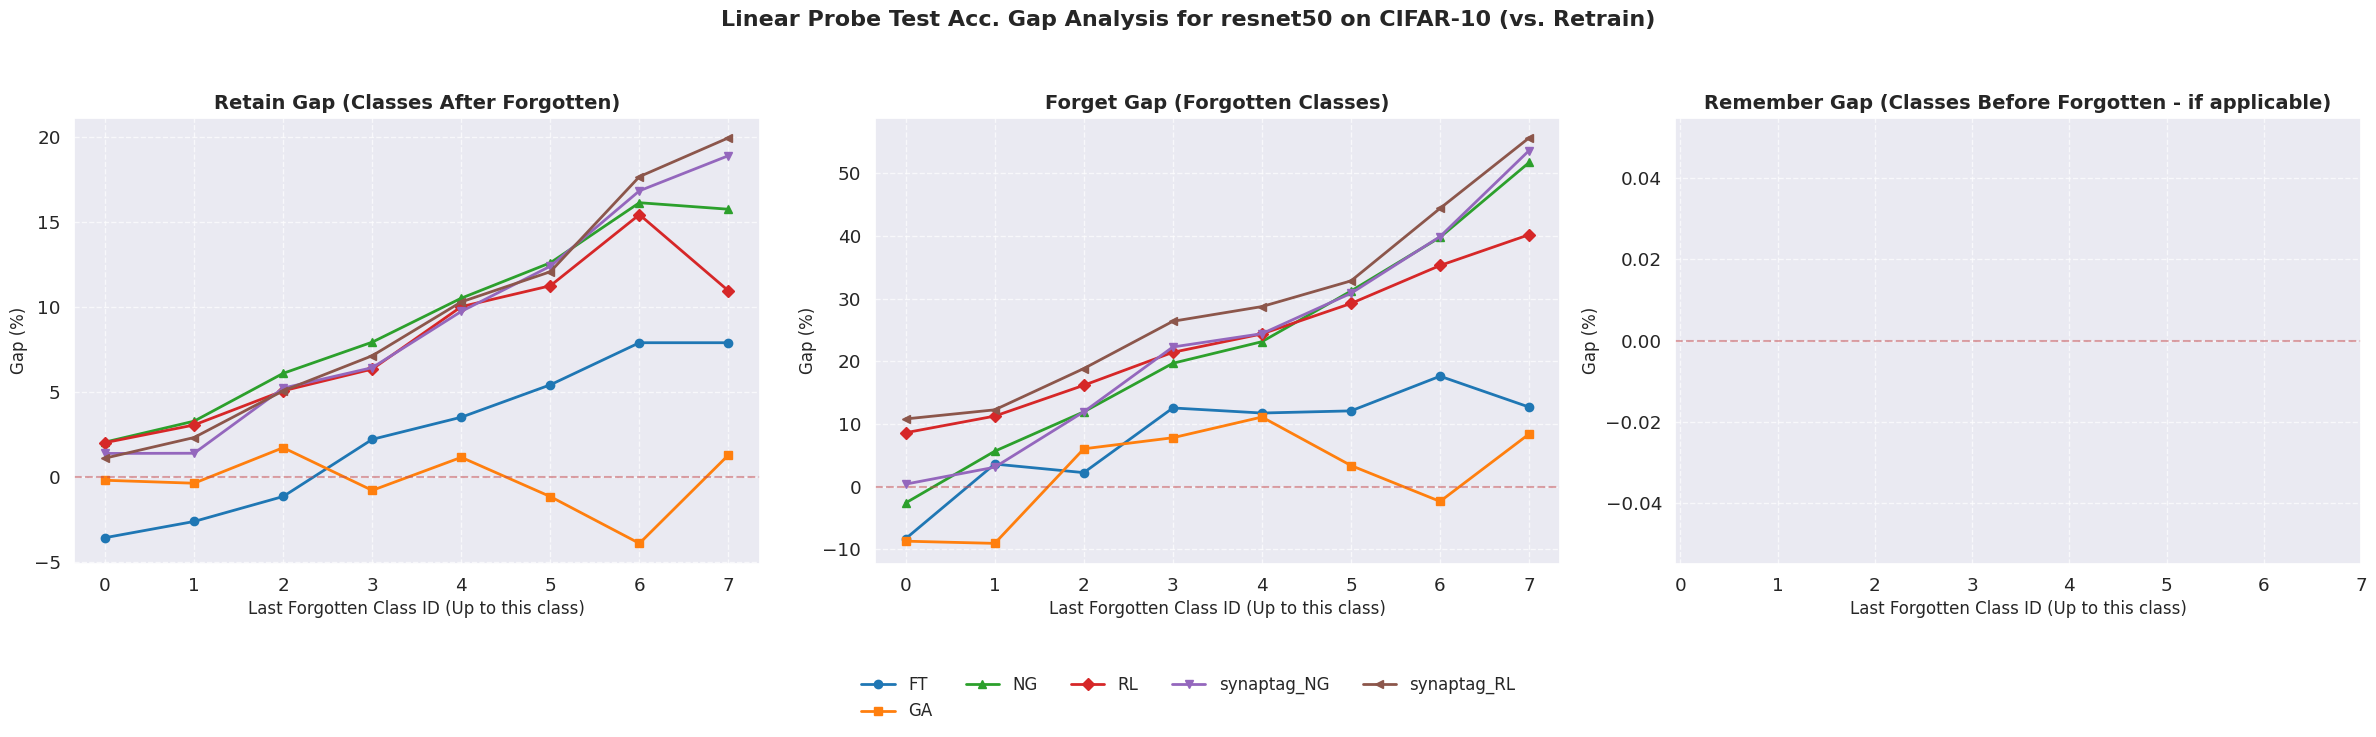

In [4]:
# Calculate the retain gap, forget gap, and remember gap for each method, model, and forget_class_end
results = []
num_classes_cifar10 = 10 # Total classes in CIFAR-10

for _, row in df.iterrows():
    if 'method' not in row or pd.isna(row['method']) or 'model' not in row or pd.isna(row['model']):
        continue

    model_name = row['model']
    end_idx = int(row['forget_class_end'])
    
    gap_columns_present = [col for col in row.index if col.startswith('LP_gap_') and not pd.isna(row[col])]
    
    retain_gap_cols = [f'LP_gap_{i}' for i in range(end_idx + 1, num_classes_cifar10) if f'LP_gap_{i}' in gap_columns_present]
    retain_gap = row[retain_gap_cols].mean() if retain_gap_cols else np.nan
    
    forget_gap_cols = [f'LP_gap_{i}' for i in range(0, end_idx + 1) if f'LP_gap_{i}' in gap_columns_present]
    forget_gap = row[forget_gap_cols].mean() if forget_gap_cols else np.nan
    
    remember_gap = np.nan
    
    results.append({
        'method': row['method'],
        'model': model_name,
        'forget_class_end': end_idx,
        'retain_gap': retain_gap,
        'forget_gap': forget_gap,
        'remember_gap': remember_gap
    })

gap_summary_df = pd.DataFrame(results).drop_duplicates()

for model_name in gap_summary_df['model'].unique():
    model_specific_gap_df = gap_summary_df[gap_summary_df['model'] == model_name]
    if model_specific_gap_df.empty:
        print(f"No gap summary data for model {model_name}")
        continue
        
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    
    methods_to_plot = sorted([m for m in model_specific_gap_df['method'].unique() if m != 'retrain'])
    colors = sns.color_palette("tab10", len(methods_to_plot))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']

    for i, method in enumerate(methods_to_plot):
        method_data = model_specific_gap_df[model_specific_gap_df['method'] == method].sort_values('forget_class_end')
        if method_data.empty:
            continue
        
        axs[0].plot(method_data['forget_class_end'], method_data['retain_gap'], 
                    marker=markers[i % len(markers)], label=method, color=colors[i % len(colors)], linewidth=2)
        axs[1].plot(method_data['forget_class_end'], method_data['forget_gap'], 
                    marker=markers[i % len(markers)], label=method, color=colors[i % len(colors)], linewidth=2)
        axs[2].plot(method_data['forget_class_end'], method_data['remember_gap'], 
                    marker=markers[i % len(markers)], label=method, color=colors[i % len(colors)], linewidth=2)

    titles = [
        'Retain Gap (Classes After Forgotten)', 
        'Forget Gap (Forgotten Classes)', 
        'Remember Gap (Classes Before Forgotten - if applicable)'
    ]
    ylabels = ['Gap (%)', 'Gap (%)', 'Gap (%)']
    unique_forget_ends = sorted(model_specific_gap_df['forget_class_end'].unique())

    for i in range(3):
        axs[i].set_title(titles[i], fontsize=14, fontweight='bold')
        axs[i].set_xlabel('Last Forgotten Class ID (Up to this class)', fontsize=12)
        axs[i].set_ylabel(ylabels[i], fontsize=12)
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        if unique_forget_ends:
            axs[i].set_xticks(unique_forget_ends)
            axs[i].set_xticklabels([str(x) for x in unique_forget_ends])

    handles, labels = axs[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
                  fancybox=True, shadow=True, ncol=min(5, len(handles)), fontsize=12)

    plt.suptitle(f'Linear Probe Test Acc. Gap Analysis for {model_name} on CIFAR-10 (vs. Retrain)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

In [5]:
# Visualize the precise metrics for different methods and models
required_metric_cols = ['precise_retain_accuracy_test', 'end_class_accuracy_test', 'precise_remember_accuracy_test']
missing_cols = [col for col in required_metric_cols if col not in df.columns]

if missing_cols:
    print(f"Missing required columns for precise metric visualization: {missing_cols}. Skipping this plot.")
else:
    for model_name in df['model'].unique():
        model_specific_df = df[df['model'] == model_name]
        if model_specific_df.empty:
            print(f"No data for model {model_name} for precise metrics.")
            continue

        methods_to_plot = sorted(model_specific_df['method'].unique())
        if not methods_to_plot or (len(methods_to_plot) == 1 and methods_to_plot[0] == 'retrain'):
            print(f"Not enough methods to plot for model {model_name} (excluding/only retrain).")
            continue

        fig, axs = plt.subplots(1, 3, figsize=(24, 7))
        colors = sns.color_palette("tab10", len(methods_to_plot))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']

        for i, method in enumerate(methods_to_plot):
            method_data = model_specific_df[model_specific_df['method'] == method].sort_values('forget_class_end')
            if method_data.empty:
                continue
            
            axs[0].plot(method_data['forget_class_end'], method_data['precise_retain_accuracy_test'], 
                        marker=markers[i % len(markers)], label=method, color=colors[i % len(colors)], linewidth=2)
            axs[1].plot(method_data['forget_class_end'], method_data['end_class_accuracy_test'], 
                        marker=markers[i % len(markers)], label=method, color=colors[i % len(colors)], linewidth=2)
            axs[2].plot(method_data['forget_class_end'], method_data['precise_remember_accuracy_test'], 
                        marker=markers[i % len(markers)], label=method, color=colors[i % len(colors)], linewidth=2)
        
        plot_titles = ['Retain Accuracy (Test)', 'Current Forget Class Accuracy (Test)', 'Remember Accuracy (Test - if applicable)']
        ylabels = ['Accuracy (%)', 'Accuracy (%)', 'Accuracy (%)']
        unique_forget_ends = sorted(model_specific_df['forget_class_end'].unique())

        for i in range(3):
            axs[i].set_title(plot_titles[i], fontsize=14, fontweight='bold')
            axs[i].set_xlabel('Last Forgotten Class ID (Up to this class)', fontsize=12)
            axs[i].set_ylabel(ylabels[i], fontsize=12)
            axs[i].grid(True, linestyle='--', alpha=0.7)
            if unique_forget_ends:
                axs[i].set_xticks(unique_forget_ends)
                axs[i].set_xticklabels([str(x) for x in unique_forget_ends])
        
        handles, labels = axs[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
                      fancybox=True, shadow=True, ncol=min(5, len(handles)), fontsize=12)
        
        plt.suptitle(f'Precise Performance Metrics for {model_name} on CIFAR-10 (Test)', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        plt.show()

Missing required columns for precise metric visualization: ['precise_retain_accuracy_test', 'end_class_accuracy_test', 'precise_remember_accuracy_test']. Skipping this plot.
